In [1]:
import pandas as pd
import os
from functools import lru_cache
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd

import read_load
import read_conditions
import central_system as cs
import envelope as evl
import appendix
from appendix import SystemSpec

## 汎用的な関数

#### 1日あたりの積算値の算出

In [2]:
def get_integration(v):
    return [v[d*24:d*24+24].sum() for d in np.arange(365)]

#### 1日あたりの平均値の算出

In [3]:
np.mean(np.array([1,2,3,4,5,6,7,8,9,10]).reshape(5,2).T, axis=0)

array([1.5, 3.5, 5.5, 7.5, 9.5])

In [4]:
def get_average(v):
    return [v[d*24:d*24+24].mean() for d in np.arange(365)]

In [5]:
def get_three_charac(v):
    return [v[d*24:d*24+24].min() for d in np.arange(365)], \
           [v[d*24:d*24+24].mean() for d in np.arange(365)], \
           [v[d*24:d*24+24].max() for d in np.arange(365)]

In [6]:
def get_five_charac(v):
    return [v[d*24:d*24+24].min() for d in np.arange(365)], \
           [np.percentile(v[d*24:d*24+24], 25) for d in np.arange(365)], \
           [v[d*24:d*24+24].mean() for d in np.arange(365)], \
           [np.percentile(v[d*24:d*24+24], 75) for d in np.arange(365)], \
           [v[d*24:d*24+24].max() for d in np.arange(365)]    

## 本シートでの計算の前提

### 地域の区分

In [7]:
REGION = 6

### 床面積

a_mr: 主たる居室の床面積, m2  
a_or: その他の居室の床面積, m2  
a_a: 床面積の合計, m2  
r_env: 床面積の合計に対する外皮の部位の面積の合計の比

#### 標準住宅

In [8]:
FLOOR_AREA = evl.FloorArea(a_mr=29.81, a_or=51.34, a_a=120.08, r_env=266.0/90.0)
#FLOOR_AREA = evl.FloorArea(a_mr=15.0, a_or=10.0, a_a=60.0, r_env=266.0/90.0)

#### 狭小住宅

後述するように、ある一定程度の規模より下の住宅においては、計算式において発散する箇所が見られたため、この分析用。

In [9]:
FLOOR_AREA_SMALL = evl.FloorArea(a_mr=5.0, a_or=10.0, a_a=20.0, r_env=266.0/90.0)

### 躯体性能

断熱水準 = 's55', 'h4', 'h11', 'h11more'  
日射遮蔽レベル = 'small', 'middle', 'large'

In [10]:
ENVELOPE = evl.Spec('h11', 'middle')

Q値の確認

In [11]:
ENVELOPE.get_q_value(region=REGION)

2.7

μ値の確認

In [12]:
ENVELOPE.get_mu_h_value(region=REGION)

0.101

In [13]:
ENVELOPE.get_mu_c_value(region=REGION)

0.062

### 設備の仕様

#### 定格能力

面積に応じて定まるデフォルト値とする

In [14]:
RATED_CAP_H, RATED_CAP_C = appendix.get_rated_capacity(region=REGION, floor_area=FLOOR_AREA)
RATED_CAP_H, RATED_CAP_C

(7733.9925600000015, 7664.646360000001)

#### ダクトの断熱

True: 断熱あり  
False: 断熱なし

In [15]:
IS_DUCT_INSULATED = True

#### 定格風量

In [16]:
RATED_SUPPLY_AIR_HEATING = 1800.0
RATED_SUPPLY_AIR_COOLING = 1800.0

In [17]:
SPEC_VAV = SystemSpec(is_duct_insulated=IS_DUCT_INSULATED, cap_rtd_h=RATED_CAP_H, cap_rtd_c=RATED_CAP_C,
                      supply_air_rtd_h=RATED_SUPPLY_AIR_HEATING, supply_air_rtd_c=RATED_SUPPLY_AIR_COOLING, vav_system=True)

In [18]:
SPEC_not_VAV = SystemSpec(is_duct_insulated=IS_DUCT_INSULATED, cap_rtd_h=RATED_CAP_H, cap_rtd_c=RATED_CAP_C,
                          supply_air_rtd_h=RATED_SUPPLY_AIR_HEATING, supply_air_rtd_c=RATED_SUPPLY_AIR_COOLING, vav_system=False)

In [19]:
def load_filter(array: np.ndarray, region : int, envelope: evl.Spec, floor_area: evl.FloorArea):
    """
    if heating load is 0.0, the array value is replaced to None
    """
    hl = np.sum(read_load.get_heating_load(region, envelope, floor_area)[0:5], axis=0)
    return np.where(hl > 0.0, array, None)

## 風量バランス

#### 標準住宅

In [20]:
cs.get_supply_air_volume_valance(FLOOR_AREA)

array([0.36734442, 0.20406654, 0.16327788, 0.13259396, 0.13271719])

#### 狭小住宅

In [21]:
cs.get_supply_air_volume_valance(FLOOR_AREA_SMALL)

array([0.33333333, 0.21503701, 0.17205558, 0.13972211, 0.13985197])

#### 合計で1.0になることの確認

In [22]:
sum(cs.get_supply_air_volume_valance(FLOOR_AREA))

1.0

In [23]:
sum(cs.get_supply_air_volume_valance(FLOOR_AREA_SMALL))

1.0

## 機械換気量

#### 標準住宅

In [24]:
cs.get_mechanical_ventilation(zone_floor_area=FLOOR_AREA)

array([60., 20., 40., 20., 20.])

#### 狭小住宅

In [25]:
cs.get_mechanical_ventilation(zone_floor_area=FLOOR_AREA_SMALL)

array([10.063737  ,  3.89559797,  7.79119595,  3.89559797,  3.89559797])

## 最低風量

#### 標準住宅

In [26]:
cs.get_minimum_air_volume(zone_floor_area=FLOOR_AREA)

(160.0, 160.0)

#### 狭小住宅

In [27]:
cs.get_minimum_air_volume(zone_floor_area=FLOOR_AREA_SMALL)

(29.54172687245164, 29.54172687245164)

## 間仕切り部分の面積

#### 標準住宅

In [28]:
cs.get_partition_area(floor_area=FLOOR_AREA)

array([37.99636619, 27.7187943 , 22.17838312, 18.01052093, 18.02725933])

#### 狭小住宅

In [29]:
cs.get_partition_area(floor_area=FLOOR_AREA_SMALL)

array([4.92592593, 4.76665368, 3.81389863, 3.09717353, 3.10005194])

## 処理負荷と未処理負荷

### 暖房

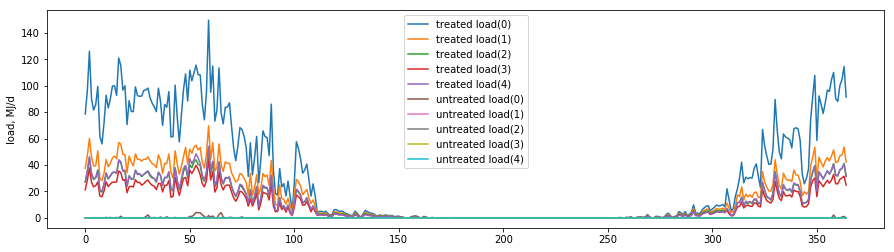

処理暖房負荷(MJ): 29696.908738603684
未処理暖房負荷(MJ): 46.01744732477817


In [30]:
xsd = np.arange(365)

yst, ysut = cs.get_treated_untreated_heat_load_for_heating(region=REGION, floor_area=FLOOR_AREA, envelope_spec=ENVELOPE, system_spec=SPEC_VAV)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
for i, yst_each in enumerate(yst):
    ax.plot(xsd, get_integration(yst_each), label='treated load(' + str(i) + ')')
for i, ysut_each in enumerate(ysut):
    ax.plot(xsd, get_integration(ysut_each), label='untreated load(' + str(i) + ')')
ax.set_ylabel('load, MJ/d')
plt.legend()
plt.show()

print('処理暖房負荷(MJ): ' + str(np.sum(yst)))
print('未処理暖房負荷(MJ): ' + str(np.sum(ysut)))

### 冷房（顕熱）

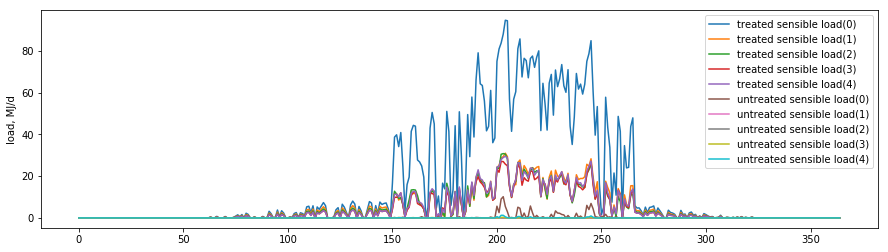

処理顕熱冷房負荷(MJ): 12268.12912593386
未処理顕熱冷房負荷(MJ): 121.82699137163998


In [31]:
xsd = np.arange(365)

yst_s, yst_l, ysut_s, ysut_l = cs.get_treated_untreated_heat_load_for_cooling(region=REGION, floor_area=FLOOR_AREA, envelope_spec=ENVELOPE, system_spec=SPEC_VAV)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
for i, yst_s_each in enumerate(yst_s):
    ax.plot(xsd, get_integration(yst_s_each), label='treated sensible load(' + str(i) + ')')
for i, ysut_s_each in enumerate(ysut_s):
    ax.plot(xsd, get_integration(ysut_s_each), label='untreated sensible load(' + str(i) + ')')
ax.set_ylabel('load, MJ/d')
plt.legend()
plt.show()

print('処理顕熱冷房負荷(MJ): ' + str(np.sum(yst_s)))
print('未処理顕熱冷房負荷(MJ): ' + str(np.sum(ysut_s)))

### 冷房（潜熱）

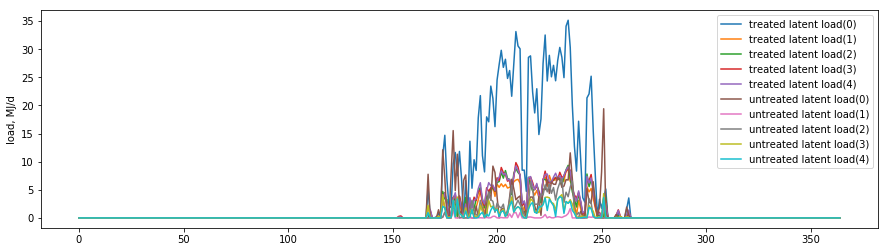

処理潜熱冷房負荷(MJ): 2816.433263341507
未処理潜熱冷房負荷(MJ): 733.7445966584932


In [32]:
xsd = np.arange(365)

yst_s, yst_l, ysut_s, ysut_l = cs.get_treated_untreated_heat_load_for_cooling(region=REGION, floor_area=FLOOR_AREA, envelope_spec=ENVELOPE, system_spec=SPEC_VAV)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
for i, yst_l_each in enumerate(yst_l):
    ax.plot(xsd, get_integration(yst_l_each), label='treated latent load(' + str(i) + ')')
for i, ysut_l_each in enumerate(ysut_l):
    ax.plot(xsd, get_integration(ysut_l_each), label='untreated latent load(' + str(i) + ')')
ax.set_ylabel('load, MJ/d')
plt.legend()
plt.show()

print('処理潜熱冷房負荷(MJ): ' + str(np.sum(yst_l)))
print('未処理潜熱冷房負荷(MJ): ' + str(np.sum(ysut_l)))

コメント：なぜか、潜熱冷房負荷でも負の値がでている。max(L,Q)の形をとるため、Lが負の値をとっている可能性がないか、追跡する必要あり。時間がなければ顕熱同様にキャップをかけてとりあえず負の値を回避する方法もあるかもしれない。

## 要求温度

### 暖房

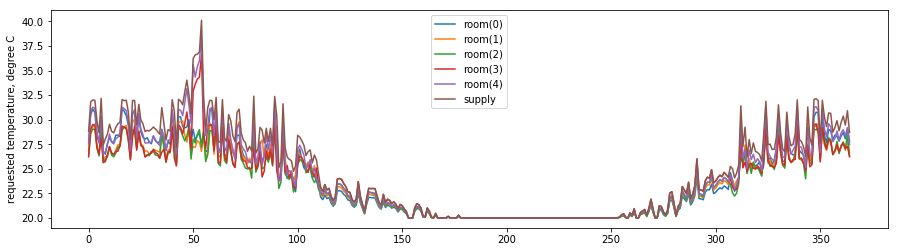

In [33]:
xsd = np.arange(365)
yss = cs.get_requested_supply_air_temperature_for_heating(
    region=REGION, floor_area=FLOOR_AREA, envelope_spec=ENVELOPE, system_spec=SPEC_VAV)
yss2 = cs.get_decided_outlet_supply_air_temperature_for_heating(
    region=REGION, floor_area=FLOOR_AREA, envelope_spec=ENVELOPE, system_spec=SPEC_VAV)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
for i, ys in enumerate(yss):
    ax.plot(xsd, get_average(ys), label='room(' + str(i) + ')')
ax.plot(xsd, get_average(yss2), label='supply')
ax.set_ylabel('requested temperature, degree C')
plt.legend()
plt.show()

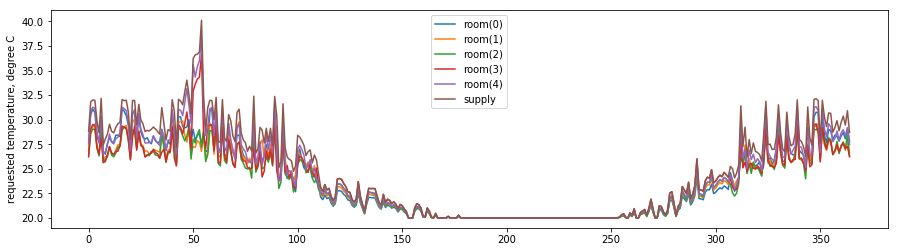

In [34]:
xsd = np.arange(365)
yss = cs.get_requested_supply_air_temperature_for_heating(
    region=REGION, floor_area=FLOOR_AREA, envelope_spec=ENVELOPE, system_spec=SPEC_not_VAV)
yss2 = cs.get_decided_outlet_supply_air_temperature_for_heating(
    region=REGION, floor_area=FLOOR_AREA, envelope_spec=ENVELOPE, system_spec=SPEC_not_VAV)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
for i, ys in enumerate(yss):
    ax.plot(xsd, get_average(ys), label='room(' + str(i) + ')')
ax.plot(xsd, get_average(yss2), label='supply')
ax.set_ylabel('requested temperature, degree C')
plt.legend()
plt.show()

### 冷房

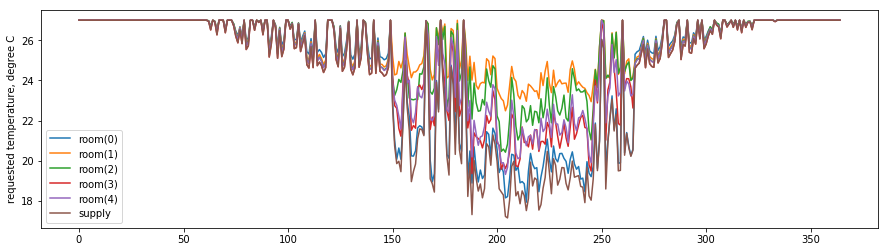

In [35]:
xsd = np.arange(365)
yss = cs.get_requested_supply_air_temperature_for_cooling(
    region=REGION, floor_area=FLOOR_AREA, envelope_spec=ENVELOPE, system_spec=SPEC_VAV)
yss2 = cs.get_decided_outlet_supply_air_temperature_for_cooling(
    region=REGION, floor_area=FLOOR_AREA, envelope_spec=ENVELOPE, system_spec=SPEC_VAV)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
for i, ys in enumerate(yss):
    ax.plot(xsd, get_average(ys), label='room(' + str(i) + ')')
ax.plot(xsd, get_average(yss2), label='supply')
ax.set_ylabel('requested temperature, degree C')
plt.legend()
plt.show()

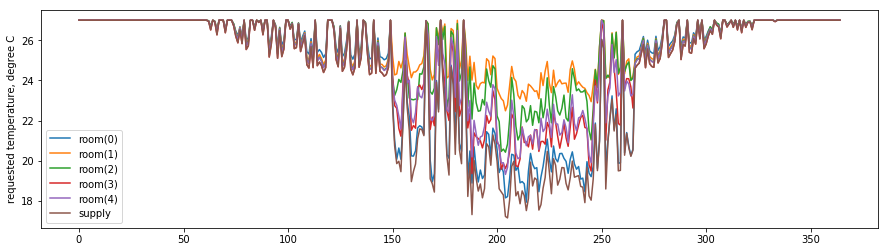

In [36]:
xsd = np.arange(365)
yss = cs.get_requested_supply_air_temperature_for_cooling(
    region=REGION, floor_area=FLOOR_AREA, envelope_spec=ENVELOPE, system_spec=SPEC_not_VAV)
yss2 = cs.get_decided_outlet_supply_air_temperature_for_cooling(
    region=REGION, floor_area=FLOOR_AREA, envelope_spec=ENVELOPE, system_spec=SPEC_VAV)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
for i, ys in enumerate(yss):
    ax.plot(xsd, get_average(ys), label='room(' + str(i) + ')')
ax.plot(xsd, get_average(yss2), label='supply')
ax.set_ylabel('requested temperature, degree C')
plt.legend()
plt.show()

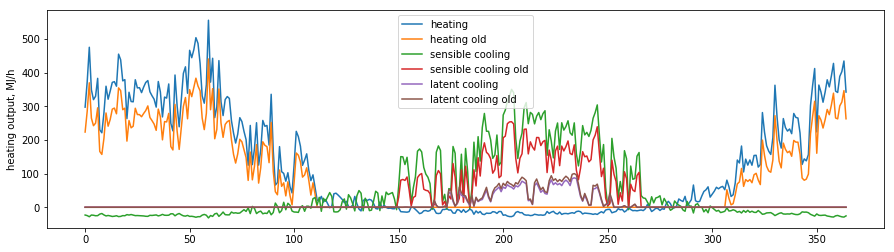

In [37]:
xsd = np.arange(365)
ys_h = cs.get_heat_source_heating_output(
    region=REGION, floor_area=FLOOR_AREA, envelope_spec=ENVELOPE, system_spec=SPEC_not_VAV)
ys_cs, ys_cl = cs.get_heat_source_cooling_output(
    region=REGION, floor_area=FLOOR_AREA, envelope_spec=ENVELOPE, system_spec=SPEC_not_VAV)
ys_h_old = np.sum(read_load.get_heating_load(region=REGION, envelope_spec=ENVELOPE, floor_area=FLOOR_AREA), axis=0)
ys_cs_old = np.sum(read_load.get_sensible_cooling_load(region=REGION, envelope_spec=ENVELOPE, floor_area=FLOOR_AREA), axis=0)
ys_cl_old = np.sum(read_load.get_latent_cooling_load(region=REGION, envelope_spec=ENVELOPE, floor_area=FLOOR_AREA), axis=0)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
ax.plot(xsd, get_integration(ys_h), label = 'heating')
ax.plot(xsd, get_integration(ys_h_old), label = 'heating old')
ax.plot(xsd, get_integration(ys_cs), label = 'sensible cooling')
ax.plot(xsd, get_integration(ys_cs_old), label = 'sensible cooling old')
ax.plot(xsd, get_integration(ys_cl), label = 'latent cooling')
ax.plot(xsd, get_integration(ys_cl_old), label = 'latent cooling old')

ax.set_ylabel('heating output, MJ/h')
plt.legend()
plt.show()